In [10]:
import loadutil
import numpy as np
import matplotlib.pyplot as plt

def create_windows(data, window_size, overlap_size):
    step_size = window_size - overlap_size
    num_windows = (len(data) - overlap_size) // step_size
    windows = np.array([
        data[i * step_size: i * step_size + window_size]
        for i in range(num_windows)
    ])
    return windows

# Load data
filename = 'dab_plane30s.bin'
window_size = 500000  # 500k samples
overlap_fraction = 0.2  # 50% overlap-
overlap_size = int(window_size * overlap_fraction)


# Read the normalized complex data
data = loadutil.read_complex_byte('dab_plane30s.bin')

# Create the overlapping windows
windows = create_windows(data, window_size, overlap_size)

if len(windows) >= 100:
    # Select window for autocorrelation - will need to iterate
    nn = windows[40]


bs = 512  # batch size
overlap = 256  # corresponds to maximum timeshift?
nbatches = int(np.floor((len(nn)-overlap)/bs))


# Now you can process 'windows' which is an array of data windows
print("Number of windows:", len(windows))

Number of windows: 153


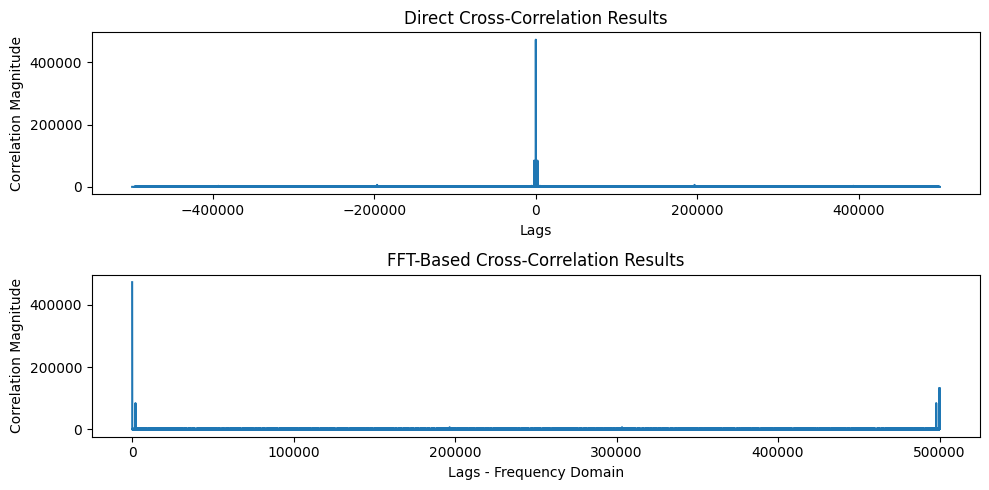

In [11]:
# Function to compute cross-correlation using FFT
import scipy.signal as signal

N = window_size
fs = 2048000 #sampling rate - 2048MS/s
t = np.arange(N)/fs #time vector
nbatches = int(np.floor((len(nn)-overlap)/bs))

def xcorr(x, y):
    rxy = signal.correlate(x, y, mode='full')
    lags = np.arange(-len(x)+1, len(x))
    return lags, rxy

# simple correlation using xcorr and fft
# note: both should give the same result, however
# the fft version is faster

# Compute the cross-correlation using the signal library
lags, rxx = xcorr(nn, nn)

# Plotting the results
[fig, ax] = plt.subplots(2, 1, figsize=(10, 5))

# First subplot: Direct cross-correlation results
ax[0].plot(lags, abs(rxx))
ax[0].set_title('Direct Cross-Correlation Results')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('Correlation Magnitude')

# Second subplot: Cross-correlation using FFT
ax[1].plot(abs(np.fft.ifft(np.fft.fft(nn) * np.conj(np.fft.fft(nn)))))
ax[1].set_title('FFT-Based Cross-Correlation Results')
ax[1].set_xlabel('Lags - Frequency Domain')
ax[1].set_ylabel('Correlation Magnitude')

plt.tight_layout()
plt.show()
    


Text(0, 0.5, 'Doppler (Hz)')

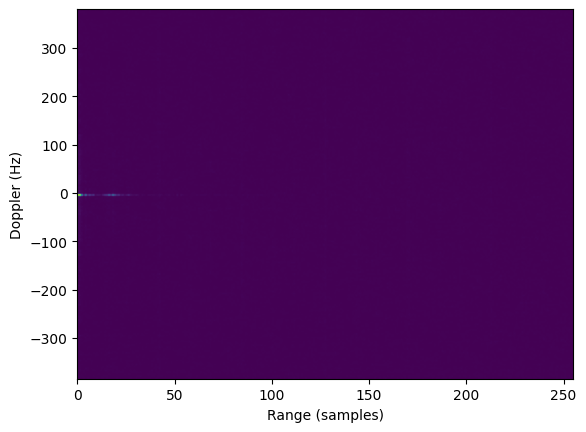

In [12]:
# Range doppler map (truncated version algorithm 2)

fmap = np.arange(-(bs*0.75), bs*0.75, 4)  # select some frequency bins

rdmapX = np.zeros((len(fmap), len(nn)), dtype=complex)
nn2F = np.conj(np.fft.fft(nn))

# for each frequency offset, calculate the time correlation
for fi in range(len(fmap)):
    f = fmap[fi]
    nnf = nn * np.exp(1j*2*np.pi*-f*t)

    rdmapX[fi,:] = np.fft.ifft(np.fft.fft(nnf) * nn2F)

# figure of RDMAP made using traditional FFT etc
stRDmap = np.zeros((nbatches, overlap))
sdata = np.size(stRDmap)
gridx = np.arange(0, overlap)
gridy = fmap

rdmapXTRUNC = rdmapX[:, 1:overlap]  # only need the first 'overlap' samples
plt.imshow(np.abs(rdmapXTRUNC), extent=[np.min(gridx), np.max(gridx), np.min(gridy), np.max(gridy)], aspect='auto')
plt.xlabel('Range (samples)')
plt.ylabel('Doppler (Hz)')
